In [2]:
from datasets import Dataset, DatasetDict, load_from_disk, load_dataset, concatenate_datasets
from PIL import Image
import pillow_heif
import requests
import math
import openai
import tqdm

import pandas as pd

import os
import io

from dotenv import load_dotenv

load_dotenv()

client = openai.OpenAI()

In [3]:
df_publicaciones = pd.read_excel('../data/dataset_correction_adicionales.xlsx')

In [4]:
df_publicaciones

,ruta,url,picture,multiple_choice_answer,val
0,../data/raw/496742632_1221674859677067_5987527...,https://scontent-ord5-2.cdninstagram.com/v/t51...,NaN,Este meme muestra a alguien rodeado de comida ...,False
1,../data/raw/495534946_655025597422524_20853943...,https://instagram.ficn7-1.fna.fbcdn.net/v/t51....,NaN,Este meme muestra al típico maestro sabio de p...,False
2,../data/raw/495839342_1395247321810626_3345731...,https://scontent-lhr8-2.cdninstagram.com/v/t51...,NaN,"Es una chimenea echando humo, como cuando elig...",False
3,../data/raw/485648693_17957093216914567_912986...,https://instagram.fnbe1-2.fna.fbcdn.net/v/t51....,NaN,Aparece un viejito tipo mago o sabio medieval ...,False
4,../data/raw/496723059_1481102066184412_8508794...,https://scontent-mia5-1.cdninstagram.com/v/t51...,NaN,"El meme muestra a un joven dentro de un auto, ...",False
...,...,...,...,...,...
69,../data/raw/470973571_1108056314187111_8161240...,https://scontent-iad3-2.cdninstagram.com/v/t51...,NaN,Muestra una ilustración estilo fantasía mediev...,False
70,../data/raw/470471491_17945219873914567_703002...,https://scontent-ord5-3.cdninstagram.com/v/t51...,NaN,Este meme refleja perfecto la sensación de cho...,False
71,../data/raw/469894424_17944890755914567_793627...,https://scontent-atl3-3.cdninstagram.com/v/t51...,NaN,Este meme parte con la portada real del álbum ...,False
72,../data/raw/469714815_17944358990914567_871618...,https://instagram.fbek1-5.fna.fbcdn.net/v/t51....,NaN,Este meme muestra a un caballero medieval sent...,False


In [5]:
TEMPLATES = [
    "Explica qué significa este meme en Chile, usando lenguaje coloquial chileno.",
    "Explica cómo entendería este meme alguien que vive en Chile, usando ejemplos culturales o referencias locales que ayuden a comprender el chiste.",
    "Describe por qué este meme sería gracioso o significativo para un chileno, destacando elementos del contexto social o cotidiano en Chile.",
    "Imagina que le explicas este meme a alguien extranjero: ¿cómo resumirías su sentido y por qué es gracioso para la gente en Chile?"
]

total_cost = 0.0

def generate_aligned_response(base_instruction, base_answer, new_instruction):
    global total_cost

    prompt = (
        f"Prompt base:\n{base_instruction}\n\n"
        f"Respuesta original:\n{base_answer}\n\n"
        f"Tarea:\nReescribe una respuesta alineada a esta nueva instrucción, solo debes devolver la respuesta:\n{new_instruction}"
    )

    rsp = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=300
    )

    usage = rsp.usage
    prompt_tokens = usage.prompt_tokens
    completion_tokens = usage.completion_tokens

    # Costos por millón de tokens (ajusta según tu cuenta)
    cost_per_million_prompt = 2.50 / 1_000_000
    cost_per_million_completion = 10.00 / 1_000_000

    call_cost = (prompt_tokens * cost_per_million_prompt) + (completion_tokens * cost_per_million_completion)
    total_cost += call_cost

    print(f"-> Esta llamada usó {prompt_tokens} prompt tokens + {completion_tokens} completion tokens = ${call_cost:.6f} USD")
    print(f"==> Gasto acumulado: ${total_cost:.6f} USD")

    return rsp.choices[0].message.content.strip()

records = []

for idx, entry in tqdm.tqdm(df_publicaciones.iterrows(), total=len(df_publicaciones)):
    img = Image.open(entry["ruta"])
    url = entry["url"]
    base_answer = entry['multiple_choice_answer']

    # Prompt base → respuesta ya validada
    records.append({
        "image": img,
        "url": url,
        "instruction": TEMPLATES[0],
        "multiple_choice_answer": base_answer,
    })

    # Para cada nueva instrucción, generar respuesta alineada
    for new_instruction in TEMPLATES[1:]:
        aligned_answer = generate_aligned_response(TEMPLATES[0], base_answer, new_instruction)
        records.append({
            "image": img,
            "url": url,
            "instruction": new_instruction,
            "multiple_choice_answer": aligned_answer,
        })

  0%|          | 0/74 [00:00<?, ?it/s]

-> Esta llamada usó 213 prompt tokens + 171 completion tokens = $0.002243 USD
==> Gasto acumulado: $0.002243 USD
-> Esta llamada usó 211 prompt tokens + 180 completion tokens = $0.002328 USD
==> Gasto acumulado: $0.004570 USD


  1%|▏         | 1/74 [00:13<16:18, 13.41s/it]

-> Esta llamada usó 216 prompt tokens + 136 completion tokens = $0.001900 USD
==> Gasto acumulado: $0.006470 USD
-> Esta llamada usó 234 prompt tokens + 157 completion tokens = $0.002155 USD
==> Gasto acumulado: $0.008625 USD
-> Esta llamada usó 232 prompt tokens + 158 completion tokens = $0.002160 USD
==> Gasto acumulado: $0.010785 USD


  3%|▎         | 2/74 [00:24<14:46, 12.31s/it]

-> Esta llamada usó 237 prompt tokens + 160 completion tokens = $0.002193 USD
==> Gasto acumulado: $0.012978 USD
-> Esta llamada usó 152 prompt tokens + 108 completion tokens = $0.001460 USD
==> Gasto acumulado: $0.014438 USD
-> Esta llamada usó 150 prompt tokens + 174 completion tokens = $0.002115 USD
==> Gasto acumulado: $0.016553 USD


  4%|▍         | 3/74 [00:34<12:57, 10.95s/it]

-> Esta llamada usó 155 prompt tokens + 94 completion tokens = $0.001328 USD
==> Gasto acumulado: $0.017880 USD
-> Esta llamada usó 269 prompt tokens + 195 completion tokens = $0.002623 USD
==> Gasto acumulado: $0.020502 USD
-> Esta llamada usó 267 prompt tokens + 188 completion tokens = $0.002548 USD
==> Gasto acumulado: $0.023050 USD


  5%|▌         | 4/74 [00:46<13:31, 11.60s/it]

-> Esta llamada usó 272 prompt tokens + 151 completion tokens = $0.002190 USD
==> Gasto acumulado: $0.025240 USD
-> Esta llamada usó 266 prompt tokens + 207 completion tokens = $0.002735 USD
==> Gasto acumulado: $0.027975 USD
-> Esta llamada usó 264 prompt tokens + 165 completion tokens = $0.002310 USD
==> Gasto acumulado: $0.030285 USD


  7%|▋         | 5/74 [01:03<15:16, 13.29s/it]

-> Esta llamada usó 269 prompt tokens + 146 completion tokens = $0.002133 USD
==> Gasto acumulado: $0.032418 USD
-> Esta llamada usó 208 prompt tokens + 149 completion tokens = $0.002010 USD
==> Gasto acumulado: $0.034427 USD
-> Esta llamada usó 206 prompt tokens + 148 completion tokens = $0.001995 USD
==> Gasto acumulado: $0.036422 USD


  8%|▊         | 6/74 [01:16<15:06, 13.33s/it]

-> Esta llamada usó 211 prompt tokens + 118 completion tokens = $0.001708 USD
==> Gasto acumulado: $0.038130 USD
-> Esta llamada usó 284 prompt tokens + 262 completion tokens = $0.003330 USD
==> Gasto acumulado: $0.041460 USD
-> Esta llamada usó 282 prompt tokens + 165 completion tokens = $0.002355 USD
==> Gasto acumulado: $0.043815 USD


  9%|▉         | 7/74 [01:32<15:40, 14.03s/it]

-> Esta llamada usó 287 prompt tokens + 125 completion tokens = $0.001968 USD
==> Gasto acumulado: $0.045782 USD
-> Esta llamada usó 322 prompt tokens + 224 completion tokens = $0.003045 USD
==> Gasto acumulado: $0.048827 USD
-> Esta llamada usó 320 prompt tokens + 186 completion tokens = $0.002660 USD
==> Gasto acumulado: $0.051487 USD


 11%|█         | 8/74 [01:42<14:12, 12.92s/it]

-> Esta llamada usó 325 prompt tokens + 167 completion tokens = $0.002483 USD
==> Gasto acumulado: $0.053970 USD
-> Esta llamada usó 196 prompt tokens + 168 completion tokens = $0.002170 USD
==> Gasto acumulado: $0.056140 USD
-> Esta llamada usó 194 prompt tokens + 208 completion tokens = $0.002565 USD
==> Gasto acumulado: $0.058705 USD


 12%|█▏        | 9/74 [01:55<14:01, 12.95s/it]

-> Esta llamada usó 199 prompt tokens + 100 completion tokens = $0.001498 USD
==> Gasto acumulado: $0.060202 USD
-> Esta llamada usó 225 prompt tokens + 154 completion tokens = $0.002103 USD
==> Gasto acumulado: $0.062305 USD
-> Esta llamada usó 223 prompt tokens + 209 completion tokens = $0.002648 USD
==> Gasto acumulado: $0.064952 USD


 14%|█▎        | 10/74 [02:11<14:48, 13.88s/it]

-> Esta llamada usó 228 prompt tokens + 149 completion tokens = $0.002060 USD
==> Gasto acumulado: $0.067013 USD
-> Esta llamada usó 259 prompt tokens + 240 completion tokens = $0.003048 USD
==> Gasto acumulado: $0.070060 USD
-> Esta llamada usó 257 prompt tokens + 133 completion tokens = $0.001973 USD
==> Gasto acumulado: $0.072032 USD


 15%|█▍        | 11/74 [02:20<12:58, 12.36s/it]

-> Esta llamada usó 262 prompt tokens + 156 completion tokens = $0.002215 USD
==> Gasto acumulado: $0.074247 USD
-> Esta llamada usó 328 prompt tokens + 300 completion tokens = $0.003820 USD
==> Gasto acumulado: $0.078067 USD
-> Esta llamada usó 326 prompt tokens + 300 completion tokens = $0.003815 USD
==> Gasto acumulado: $0.081882 USD


 16%|█▌        | 12/74 [02:39<14:58, 14.49s/it]

-> Esta llamada usó 331 prompt tokens + 195 completion tokens = $0.002778 USD
==> Gasto acumulado: $0.084660 USD
-> Esta llamada usó 259 prompt tokens + 217 completion tokens = $0.002818 USD
==> Gasto acumulado: $0.087477 USD
-> Esta llamada usó 257 prompt tokens + 190 completion tokens = $0.002543 USD
==> Gasto acumulado: $0.090020 USD


 18%|█▊        | 13/74 [02:50<13:42, 13.48s/it]

-> Esta llamada usó 262 prompt tokens + 138 completion tokens = $0.002035 USD
==> Gasto acumulado: $0.092055 USD
-> Esta llamada usó 263 prompt tokens + 209 completion tokens = $0.002748 USD
==> Gasto acumulado: $0.094802 USD
-> Esta llamada usó 261 prompt tokens + 205 completion tokens = $0.002703 USD
==> Gasto acumulado: $0.097505 USD


 19%|█▉        | 14/74 [03:03<13:18, 13.30s/it]

-> Esta llamada usó 266 prompt tokens + 201 completion tokens = $0.002675 USD
==> Gasto acumulado: $0.100180 USD
-> Esta llamada usó 294 prompt tokens + 203 completion tokens = $0.002765 USD
==> Gasto acumulado: $0.102945 USD
-> Esta llamada usó 292 prompt tokens + 165 completion tokens = $0.002380 USD
==> Gasto acumulado: $0.105325 USD


 20%|██        | 15/74 [03:18<13:35, 13.83s/it]

-> Esta llamada usó 297 prompt tokens + 180 completion tokens = $0.002543 USD
==> Gasto acumulado: $0.107868 USD
-> Esta llamada usó 211 prompt tokens + 152 completion tokens = $0.002048 USD
==> Gasto acumulado: $0.109915 USD
-> Esta llamada usó 209 prompt tokens + 173 completion tokens = $0.002253 USD
==> Gasto acumulado: $0.112168 USD


 22%|██▏       | 16/74 [03:31<13:04, 13.52s/it]

-> Esta llamada usó 214 prompt tokens + 126 completion tokens = $0.001795 USD
==> Gasto acumulado: $0.113963 USD
-> Esta llamada usó 180 prompt tokens + 166 completion tokens = $0.002110 USD
==> Gasto acumulado: $0.116073 USD
-> Esta llamada usó 178 prompt tokens + 148 completion tokens = $0.001925 USD
==> Gasto acumulado: $0.117998 USD


 23%|██▎       | 17/74 [03:43<12:12, 12.84s/it]

-> Esta llamada usó 183 prompt tokens + 126 completion tokens = $0.001718 USD
==> Gasto acumulado: $0.119715 USD
-> Esta llamada usó 280 prompt tokens + 166 completion tokens = $0.002360 USD
==> Gasto acumulado: $0.122075 USD
-> Esta llamada usó 278 prompt tokens + 193 completion tokens = $0.002625 USD
==> Gasto acumulado: $0.124700 USD


 24%|██▍       | 18/74 [03:59<13:05, 14.03s/it]

-> Esta llamada usó 283 prompt tokens + 159 completion tokens = $0.002298 USD
==> Gasto acumulado: $0.126998 USD
-> Esta llamada usó 207 prompt tokens + 183 completion tokens = $0.002348 USD
==> Gasto acumulado: $0.129345 USD
-> Esta llamada usó 205 prompt tokens + 158 completion tokens = $0.002093 USD
==> Gasto acumulado: $0.131438 USD


 26%|██▌       | 19/74 [04:11<12:07, 13.23s/it]

-> Esta llamada usó 210 prompt tokens + 118 completion tokens = $0.001705 USD
==> Gasto acumulado: $0.133143 USD
-> Esta llamada usó 175 prompt tokens + 110 completion tokens = $0.001538 USD
==> Gasto acumulado: $0.134680 USD
-> Esta llamada usó 173 prompt tokens + 136 completion tokens = $0.001793 USD
==> Gasto acumulado: $0.136473 USD


 27%|██▋       | 20/74 [04:19<10:37, 11.81s/it]

-> Esta llamada usó 178 prompt tokens + 112 completion tokens = $0.001565 USD
==> Gasto acumulado: $0.138038 USD
-> Esta llamada usó 253 prompt tokens + 199 completion tokens = $0.002622 USD
==> Gasto acumulado: $0.140660 USD
-> Esta llamada usó 251 prompt tokens + 164 completion tokens = $0.002268 USD
==> Gasto acumulado: $0.142928 USD


 28%|██▊       | 21/74 [04:28<09:35, 10.85s/it]

-> Esta llamada usó 256 prompt tokens + 125 completion tokens = $0.001890 USD
==> Gasto acumulado: $0.144818 USD
-> Esta llamada usó 243 prompt tokens + 195 completion tokens = $0.002558 USD
==> Gasto acumulado: $0.147375 USD
-> Esta llamada usó 241 prompt tokens + 164 completion tokens = $0.002243 USD
==> Gasto acumulado: $0.149618 USD


 30%|██▉       | 22/74 [04:41<09:54, 11.43s/it]

-> Esta llamada usó 246 prompt tokens + 151 completion tokens = $0.002125 USD
==> Gasto acumulado: $0.151743 USD
-> Esta llamada usó 283 prompt tokens + 286 completion tokens = $0.003568 USD
==> Gasto acumulado: $0.155310 USD
-> Esta llamada usó 281 prompt tokens + 166 completion tokens = $0.002363 USD
==> Gasto acumulado: $0.157673 USD


 31%|███       | 23/74 [04:56<10:36, 12.49s/it]

-> Esta llamada usó 286 prompt tokens + 117 completion tokens = $0.001885 USD
==> Gasto acumulado: $0.159558 USD
-> Esta llamada usó 186 prompt tokens + 168 completion tokens = $0.002145 USD
==> Gasto acumulado: $0.161703 USD
-> Esta llamada usó 184 prompt tokens + 167 completion tokens = $0.002130 USD
==> Gasto acumulado: $0.163833 USD


 32%|███▏      | 24/74 [05:08<10:27, 12.55s/it]

-> Esta llamada usó 189 prompt tokens + 116 completion tokens = $0.001633 USD
==> Gasto acumulado: $0.165465 USD
-> Esta llamada usó 198 prompt tokens + 148 completion tokens = $0.001975 USD
==> Gasto acumulado: $0.167440 USD
-> Esta llamada usó 196 prompt tokens + 163 completion tokens = $0.002120 USD
==> Gasto acumulado: $0.169560 USD


 34%|███▍      | 25/74 [05:17<09:13, 11.31s/it]

-> Esta llamada usó 201 prompt tokens + 131 completion tokens = $0.001813 USD
==> Gasto acumulado: $0.171373 USD
-> Esta llamada usó 171 prompt tokens + 116 completion tokens = $0.001587 USD
==> Gasto acumulado: $0.172960 USD
-> Esta llamada usó 169 prompt tokens + 137 completion tokens = $0.001793 USD
==> Gasto acumulado: $0.174753 USD


 35%|███▌      | 26/74 [05:26<08:41, 10.87s/it]

-> Esta llamada usó 174 prompt tokens + 98 completion tokens = $0.001415 USD
==> Gasto acumulado: $0.176168 USD
-> Esta llamada usó 265 prompt tokens + 213 completion tokens = $0.002793 USD
==> Gasto acumulado: $0.178960 USD
-> Esta llamada usó 263 prompt tokens + 171 completion tokens = $0.002368 USD
==> Gasto acumulado: $0.181328 USD


 36%|███▋      | 27/74 [05:41<09:25, 12.02s/it]

-> Esta llamada usó 268 prompt tokens + 187 completion tokens = $0.002540 USD
==> Gasto acumulado: $0.183868 USD
-> Esta llamada usó 196 prompt tokens + 141 completion tokens = $0.001900 USD
==> Gasto acumulado: $0.185768 USD
-> Esta llamada usó 194 prompt tokens + 137 completion tokens = $0.001855 USD
==> Gasto acumulado: $0.187623 USD


 38%|███▊      | 28/74 [05:54<09:30, 12.39s/it]

-> Esta llamada usó 199 prompt tokens + 129 completion tokens = $0.001788 USD
==> Gasto acumulado: $0.189410 USD
-> Esta llamada usó 241 prompt tokens + 244 completion tokens = $0.003043 USD
==> Gasto acumulado: $0.192453 USD
-> Esta llamada usó 239 prompt tokens + 196 completion tokens = $0.002558 USD
==> Gasto acumulado: $0.195010 USD


 39%|███▉      | 29/74 [06:10<09:54, 13.21s/it]

-> Esta llamada usó 244 prompt tokens + 197 completion tokens = $0.002580 USD
==> Gasto acumulado: $0.197590 USD
-> Esta llamada usó 279 prompt tokens + 223 completion tokens = $0.002928 USD
==> Gasto acumulado: $0.200518 USD
-> Esta llamada usó 277 prompt tokens + 190 completion tokens = $0.002593 USD
==> Gasto acumulado: $0.203110 USD


 41%|████      | 30/74 [06:22<09:30, 12.96s/it]

-> Esta llamada usó 282 prompt tokens + 150 completion tokens = $0.002205 USD
==> Gasto acumulado: $0.205315 USD
-> Esta llamada usó 311 prompt tokens + 225 completion tokens = $0.003028 USD
==> Gasto acumulado: $0.208343 USD
-> Esta llamada usó 309 prompt tokens + 225 completion tokens = $0.003023 USD
==> Gasto acumulado: $0.211365 USD


 42%|████▏     | 31/74 [06:34<09:03, 12.64s/it]

-> Esta llamada usó 314 prompt tokens + 172 completion tokens = $0.002505 USD
==> Gasto acumulado: $0.213870 USD
-> Esta llamada usó 205 prompt tokens + 158 completion tokens = $0.002093 USD
==> Gasto acumulado: $0.215963 USD
-> Esta llamada usó 203 prompt tokens + 178 completion tokens = $0.002288 USD
==> Gasto acumulado: $0.218250 USD


 43%|████▎     | 32/74 [06:45<08:37, 12.32s/it]

-> Esta llamada usó 208 prompt tokens + 123 completion tokens = $0.001750 USD
==> Gasto acumulado: $0.220000 USD
-> Esta llamada usó 285 prompt tokens + 252 completion tokens = $0.003233 USD
==> Gasto acumulado: $0.223233 USD
-> Esta llamada usó 283 prompt tokens + 229 completion tokens = $0.002998 USD
==> Gasto acumulado: $0.226230 USD


 45%|████▍     | 33/74 [06:59<08:38, 12.65s/it]

-> Esta llamada usó 288 prompt tokens + 184 completion tokens = $0.002560 USD
==> Gasto acumulado: $0.228790 USD
-> Esta llamada usó 281 prompt tokens + 300 completion tokens = $0.003703 USD
==> Gasto acumulado: $0.232493 USD
-> Esta llamada usó 279 prompt tokens + 235 completion tokens = $0.003048 USD
==> Gasto acumulado: $0.235540 USD


 46%|████▌     | 34/74 [07:16<09:21, 14.04s/it]

-> Esta llamada usó 284 prompt tokens + 136 completion tokens = $0.002070 USD
==> Gasto acumulado: $0.237610 USD
-> Esta llamada usó 284 prompt tokens + 274 completion tokens = $0.003450 USD
==> Gasto acumulado: $0.241060 USD
-> Esta llamada usó 282 prompt tokens + 255 completion tokens = $0.003255 USD
==> Gasto acumulado: $0.244315 USD


 47%|████▋     | 35/74 [07:42<11:28, 17.67s/it]

-> Esta llamada usó 287 prompt tokens + 222 completion tokens = $0.002938 USD
==> Gasto acumulado: $0.247253 USD
-> Esta llamada usó 292 prompt tokens + 252 completion tokens = $0.003250 USD
==> Gasto acumulado: $0.250503 USD
-> Esta llamada usó 290 prompt tokens + 199 completion tokens = $0.002715 USD
==> Gasto acumulado: $0.253218 USD


 49%|████▊     | 36/74 [07:57<10:33, 16.67s/it]

-> Esta llamada usó 295 prompt tokens + 193 completion tokens = $0.002668 USD
==> Gasto acumulado: $0.255885 USD
-> Esta llamada usó 328 prompt tokens + 247 completion tokens = $0.003290 USD
==> Gasto acumulado: $0.259175 USD
-> Esta llamada usó 326 prompt tokens + 193 completion tokens = $0.002745 USD
==> Gasto acumulado: $0.261920 USD


 50%|█████     | 37/74 [08:14<10:27, 16.97s/it]

-> Esta llamada usó 331 prompt tokens + 136 completion tokens = $0.002188 USD
==> Gasto acumulado: $0.264108 USD
-> Esta llamada usó 289 prompt tokens + 232 completion tokens = $0.003043 USD
==> Gasto acumulado: $0.267150 USD
-> Esta llamada usó 287 prompt tokens + 173 completion tokens = $0.002448 USD
==> Gasto acumulado: $0.269598 USD


 51%|█████▏    | 38/74 [08:27<09:22, 15.62s/it]

-> Esta llamada usó 292 prompt tokens + 198 completion tokens = $0.002710 USD
==> Gasto acumulado: $0.272308 USD
-> Esta llamada usó 211 prompt tokens + 170 completion tokens = $0.002228 USD
==> Gasto acumulado: $0.274535 USD
-> Esta llamada usó 209 prompt tokens + 132 completion tokens = $0.001843 USD
==> Gasto acumulado: $0.276378 USD


 53%|█████▎    | 39/74 [08:34<07:41, 13.19s/it]

-> Esta llamada usó 214 prompt tokens + 95 completion tokens = $0.001485 USD
==> Gasto acumulado: $0.277863 USD
-> Esta llamada usó 243 prompt tokens + 218 completion tokens = $0.002788 USD
==> Gasto acumulado: $0.280650 USD
-> Esta llamada usó 241 prompt tokens + 151 completion tokens = $0.002113 USD
==> Gasto acumulado: $0.282763 USD


 54%|█████▍    | 40/74 [08:44<06:52, 12.12s/it]

-> Esta llamada usó 246 prompt tokens + 162 completion tokens = $0.002235 USD
==> Gasto acumulado: $0.284998 USD
-> Esta llamada usó 260 prompt tokens + 242 completion tokens = $0.003070 USD
==> Gasto acumulado: $0.288068 USD
-> Esta llamada usó 258 prompt tokens + 192 completion tokens = $0.002565 USD
==> Gasto acumulado: $0.290633 USD


 55%|█████▌    | 41/74 [08:55<06:34, 11.96s/it]

-> Esta llamada usó 263 prompt tokens + 170 completion tokens = $0.002358 USD
==> Gasto acumulado: $0.292990 USD
-> Esta llamada usó 240 prompt tokens + 192 completion tokens = $0.002520 USD
==> Gasto acumulado: $0.295510 USD
-> Esta llamada usó 238 prompt tokens + 149 completion tokens = $0.002085 USD
==> Gasto acumulado: $0.297595 USD


 57%|█████▋    | 42/74 [09:06<06:12, 11.64s/it]

-> Esta llamada usó 243 prompt tokens + 153 completion tokens = $0.002138 USD
==> Gasto acumulado: $0.299733 USD
-> Esta llamada usó 199 prompt tokens + 117 completion tokens = $0.001668 USD
==> Gasto acumulado: $0.301400 USD
-> Esta llamada usó 197 prompt tokens + 161 completion tokens = $0.002103 USD
==> Gasto acumulado: $0.303503 USD


 58%|█████▊    | 43/74 [09:15<05:30, 10.66s/it]

-> Esta llamada usó 202 prompt tokens + 107 completion tokens = $0.001575 USD
==> Gasto acumulado: $0.305078 USD
-> Esta llamada usó 232 prompt tokens + 186 completion tokens = $0.002440 USD
==> Gasto acumulado: $0.307518 USD
-> Esta llamada usó 230 prompt tokens + 155 completion tokens = $0.002125 USD
==> Gasto acumulado: $0.309643 USD


 59%|█████▉    | 44/74 [09:27<05:37, 11.24s/it]

-> Esta llamada usó 235 prompt tokens + 162 completion tokens = $0.002208 USD
==> Gasto acumulado: $0.311850 USD
-> Esta llamada usó 310 prompt tokens + 221 completion tokens = $0.002985 USD
==> Gasto acumulado: $0.314835 USD
-> Esta llamada usó 308 prompt tokens + 176 completion tokens = $0.002530 USD
==> Gasto acumulado: $0.317365 USD


 61%|██████    | 45/74 [09:41<05:47, 11.98s/it]

-> Esta llamada usó 313 prompt tokens + 188 completion tokens = $0.002663 USD
==> Gasto acumulado: $0.320028 USD
-> Esta llamada usó 276 prompt tokens + 228 completion tokens = $0.002970 USD
==> Gasto acumulado: $0.322998 USD
-> Esta llamada usó 274 prompt tokens + 203 completion tokens = $0.002715 USD
==> Gasto acumulado: $0.325713 USD


 62%|██████▏   | 46/74 [09:51<05:14, 11.24s/it]

-> Esta llamada usó 279 prompt tokens + 139 completion tokens = $0.002088 USD
==> Gasto acumulado: $0.327800 USD
-> Esta llamada usó 281 prompt tokens + 248 completion tokens = $0.003182 USD
==> Gasto acumulado: $0.330983 USD
-> Esta llamada usó 279 prompt tokens + 141 completion tokens = $0.002107 USD
==> Gasto acumulado: $0.333090 USD


 64%|██████▎   | 47/74 [10:01<04:54, 10.91s/it]

-> Esta llamada usó 284 prompt tokens + 143 completion tokens = $0.002140 USD
==> Gasto acumulado: $0.335230 USD
-> Esta llamada usó 300 prompt tokens + 243 completion tokens = $0.003180 USD
==> Gasto acumulado: $0.338410 USD
-> Esta llamada usó 298 prompt tokens + 228 completion tokens = $0.003025 USD
==> Gasto acumulado: $0.341435 USD


 65%|██████▍   | 48/74 [10:14<04:59, 11.51s/it]

-> Esta llamada usó 303 prompt tokens + 180 completion tokens = $0.002558 USD
==> Gasto acumulado: $0.343993 USD
-> Esta llamada usó 247 prompt tokens + 216 completion tokens = $0.002778 USD
==> Gasto acumulado: $0.346770 USD
-> Esta llamada usó 245 prompt tokens + 158 completion tokens = $0.002193 USD
==> Gasto acumulado: $0.348963 USD


 66%|██████▌   | 49/74 [10:30<05:25, 13.03s/it]

-> Esta llamada usó 250 prompt tokens + 188 completion tokens = $0.002505 USD
==> Gasto acumulado: $0.351468 USD
-> Esta llamada usó 257 prompt tokens + 187 completion tokens = $0.002512 USD
==> Gasto acumulado: $0.353980 USD
-> Esta llamada usó 255 prompt tokens + 189 completion tokens = $0.002528 USD
==> Gasto acumulado: $0.356508 USD


 68%|██████▊   | 50/74 [10:40<04:52, 12.20s/it]

-> Esta llamada usó 260 prompt tokens + 168 completion tokens = $0.002330 USD
==> Gasto acumulado: $0.358838 USD
-> Esta llamada usó 440 prompt tokens + 300 completion tokens = $0.004100 USD
==> Gasto acumulado: $0.362938 USD
-> Esta llamada usó 438 prompt tokens + 244 completion tokens = $0.003535 USD
==> Gasto acumulado: $0.366473 USD


 69%|██████▉   | 51/74 [11:01<05:39, 14.74s/it]

-> Esta llamada usó 443 prompt tokens + 176 completion tokens = $0.002868 USD
==> Gasto acumulado: $0.369340 USD
-> Esta llamada usó 239 prompt tokens + 245 completion tokens = $0.003048 USD
==> Gasto acumulado: $0.372388 USD
-> Esta llamada usó 237 prompt tokens + 240 completion tokens = $0.002993 USD
==> Gasto acumulado: $0.375380 USD


 70%|███████   | 52/74 [11:17<05:33, 15.14s/it]

-> Esta llamada usó 242 prompt tokens + 181 completion tokens = $0.002415 USD
==> Gasto acumulado: $0.377795 USD
-> Esta llamada usó 315 prompt tokens + 236 completion tokens = $0.003148 USD
==> Gasto acumulado: $0.380943 USD
-> Esta llamada usó 313 prompt tokens + 198 completion tokens = $0.002763 USD
==> Gasto acumulado: $0.383705 USD


 72%|███████▏  | 53/74 [11:29<04:54, 14.02s/it]

-> Esta llamada usó 318 prompt tokens + 163 completion tokens = $0.002425 USD
==> Gasto acumulado: $0.386130 USD
-> Esta llamada usó 324 prompt tokens + 300 completion tokens = $0.003810 USD
==> Gasto acumulado: $0.389940 USD
-> Esta llamada usó 322 prompt tokens + 209 completion tokens = $0.002895 USD
==> Gasto acumulado: $0.392835 USD


 73%|███████▎  | 54/74 [11:38<04:11, 12.57s/it]

-> Esta llamada usó 327 prompt tokens + 135 completion tokens = $0.002168 USD
==> Gasto acumulado: $0.395003 USD
-> Esta llamada usó 287 prompt tokens + 238 completion tokens = $0.003098 USD
==> Gasto acumulado: $0.398100 USD
-> Esta llamada usó 285 prompt tokens + 165 completion tokens = $0.002363 USD
==> Gasto acumulado: $0.400463 USD


 74%|███████▍  | 55/74 [11:51<04:00, 12.67s/it]

-> Esta llamada usó 290 prompt tokens + 145 completion tokens = $0.002175 USD
==> Gasto acumulado: $0.402638 USD
-> Esta llamada usó 257 prompt tokens + 300 completion tokens = $0.003642 USD
==> Gasto acumulado: $0.406280 USD
-> Esta llamada usó 255 prompt tokens + 185 completion tokens = $0.002488 USD
==> Gasto acumulado: $0.408768 USD


 76%|███████▌  | 56/74 [12:04<03:53, 12.99s/it]

-> Esta llamada usó 260 prompt tokens + 144 completion tokens = $0.002090 USD
==> Gasto acumulado: $0.410857 USD
-> Esta llamada usó 203 prompt tokens + 156 completion tokens = $0.002068 USD
==> Gasto acumulado: $0.412925 USD
-> Esta llamada usó 201 prompt tokens + 146 completion tokens = $0.001963 USD
==> Gasto acumulado: $0.414887 USD


 77%|███████▋  | 57/74 [12:16<03:33, 12.53s/it]

-> Esta llamada usó 206 prompt tokens + 137 completion tokens = $0.001885 USD
==> Gasto acumulado: $0.416772 USD
-> Esta llamada usó 361 prompt tokens + 300 completion tokens = $0.003903 USD
==> Gasto acumulado: $0.420675 USD
-> Esta llamada usó 359 prompt tokens + 181 completion tokens = $0.002708 USD
==> Gasto acumulado: $0.423382 USD


 78%|███████▊  | 58/74 [12:28<03:17, 12.32s/it]

-> Esta llamada usó 364 prompt tokens + 205 completion tokens = $0.002960 USD
==> Gasto acumulado: $0.426342 USD
-> Esta llamada usó 258 prompt tokens + 261 completion tokens = $0.003255 USD
==> Gasto acumulado: $0.429597 USD
-> Esta llamada usó 256 prompt tokens + 231 completion tokens = $0.002950 USD
==> Gasto acumulado: $0.432547 USD


 80%|███████▉  | 59/74 [12:44<03:21, 13.45s/it]

-> Esta llamada usó 261 prompt tokens + 202 completion tokens = $0.002673 USD
==> Gasto acumulado: $0.435220 USD
-> Esta llamada usó 327 prompt tokens + 279 completion tokens = $0.003608 USD
==> Gasto acumulado: $0.438827 USD
-> Esta llamada usó 325 prompt tokens + 170 completion tokens = $0.002512 USD
==> Gasto acumulado: $0.441340 USD


 81%|████████  | 60/74 [12:57<03:07, 13.42s/it]

-> Esta llamada usó 330 prompt tokens + 171 completion tokens = $0.002535 USD
==> Gasto acumulado: $0.443875 USD
-> Esta llamada usó 272 prompt tokens + 225 completion tokens = $0.002930 USD
==> Gasto acumulado: $0.446805 USD
-> Esta llamada usó 270 prompt tokens + 145 completion tokens = $0.002125 USD
==> Gasto acumulado: $0.448930 USD


 82%|████████▏ | 61/74 [13:11<02:56, 13.57s/it]

-> Esta llamada usó 275 prompt tokens + 182 completion tokens = $0.002508 USD
==> Gasto acumulado: $0.451437 USD
-> Esta llamada usó 315 prompt tokens + 240 completion tokens = $0.003188 USD
==> Gasto acumulado: $0.454625 USD
-> Esta llamada usó 313 prompt tokens + 232 completion tokens = $0.003103 USD
==> Gasto acumulado: $0.457727 USD


 84%|████████▍ | 62/74 [13:24<02:39, 13.31s/it]

-> Esta llamada usó 318 prompt tokens + 157 completion tokens = $0.002365 USD
==> Gasto acumulado: $0.460092 USD
-> Esta llamada usó 377 prompt tokens + 300 completion tokens = $0.003942 USD
==> Gasto acumulado: $0.464035 USD
-> Esta llamada usó 375 prompt tokens + 180 completion tokens = $0.002738 USD
==> Gasto acumulado: $0.466772 USD


 85%|████████▌ | 63/74 [13:35<02:20, 12.78s/it]

-> Esta llamada usó 380 prompt tokens + 300 completion tokens = $0.003950 USD
==> Gasto acumulado: $0.470722 USD
-> Esta llamada usó 286 prompt tokens + 245 completion tokens = $0.003165 USD
==> Gasto acumulado: $0.473887 USD
-> Esta llamada usó 284 prompt tokens + 175 completion tokens = $0.002460 USD
==> Gasto acumulado: $0.476347 USD


 86%|████████▋ | 64/74 [13:48<02:07, 12.79s/it]

-> Esta llamada usó 289 prompt tokens + 164 completion tokens = $0.002363 USD
==> Gasto acumulado: $0.478710 USD
-> Esta llamada usó 278 prompt tokens + 194 completion tokens = $0.002635 USD
==> Gasto acumulado: $0.481345 USD
-> Esta llamada usó 276 prompt tokens + 195 completion tokens = $0.002640 USD
==> Gasto acumulado: $0.483985 USD


 88%|████████▊ | 65/74 [14:02<01:57, 13.10s/it]

-> Esta llamada usó 281 prompt tokens + 159 completion tokens = $0.002293 USD
==> Gasto acumulado: $0.486277 USD
-> Esta llamada usó 261 prompt tokens + 206 completion tokens = $0.002713 USD
==> Gasto acumulado: $0.488990 USD
-> Esta llamada usó 259 prompt tokens + 182 completion tokens = $0.002468 USD
==> Gasto acumulado: $0.491457 USD


 89%|████████▉ | 66/74 [14:11<01:34, 11.81s/it]

-> Esta llamada usó 264 prompt tokens + 119 completion tokens = $0.001850 USD
==> Gasto acumulado: $0.493307 USD
-> Esta llamada usó 287 prompt tokens + 162 completion tokens = $0.002338 USD
==> Gasto acumulado: $0.495645 USD
-> Esta llamada usó 285 prompt tokens + 180 completion tokens = $0.002512 USD
==> Gasto acumulado: $0.498157 USD


 91%|█████████ | 67/74 [14:26<01:29, 12.79s/it]

-> Esta llamada usó 290 prompt tokens + 138 completion tokens = $0.002105 USD
==> Gasto acumulado: $0.500262 USD
-> Esta llamada usó 292 prompt tokens + 266 completion tokens = $0.003390 USD
==> Gasto acumulado: $0.503652 USD
-> Esta llamada usó 290 prompt tokens + 208 completion tokens = $0.002805 USD
==> Gasto acumulado: $0.506457 USD


 92%|█████████▏| 68/74 [14:38<01:16, 12.76s/it]

-> Esta llamada usó 295 prompt tokens + 206 completion tokens = $0.002798 USD
==> Gasto acumulado: $0.509255 USD
-> Esta llamada usó 259 prompt tokens + 249 completion tokens = $0.003138 USD
==> Gasto acumulado: $0.512392 USD
-> Esta llamada usó 257 prompt tokens + 227 completion tokens = $0.002913 USD
==> Gasto acumulado: $0.515305 USD


 93%|█████████▎| 69/74 [14:49<01:00, 12.19s/it]

-> Esta llamada usó 262 prompt tokens + 131 completion tokens = $0.001965 USD
==> Gasto acumulado: $0.517270 USD
-> Esta llamada usó 268 prompt tokens + 144 completion tokens = $0.002110 USD
==> Gasto acumulado: $0.519380 USD
-> Esta llamada usó 266 prompt tokens + 170 completion tokens = $0.002365 USD
==> Gasto acumulado: $0.521745 USD


 95%|█████████▍| 70/74 [15:03<00:50, 12.58s/it]

-> Esta llamada usó 271 prompt tokens + 138 completion tokens = $0.002058 USD
==> Gasto acumulado: $0.523802 USD
-> Esta llamada usó 190 prompt tokens + 135 completion tokens = $0.001825 USD
==> Gasto acumulado: $0.525627 USD
-> Esta llamada usó 188 prompt tokens + 160 completion tokens = $0.002070 USD
==> Gasto acumulado: $0.527697 USD


 96%|█████████▌| 71/74 [15:13<00:35, 11.83s/it]

-> Esta llamada usó 193 prompt tokens + 131 completion tokens = $0.001793 USD
==> Gasto acumulado: $0.529490 USD
-> Esta llamada usó 289 prompt tokens + 251 completion tokens = $0.003233 USD
==> Gasto acumulado: $0.532722 USD
-> Esta llamada usó 287 prompt tokens + 213 completion tokens = $0.002848 USD
==> Gasto acumulado: $0.535570 USD


 97%|█████████▋| 72/74 [15:27<00:25, 12.61s/it]

-> Esta llamada usó 292 prompt tokens + 165 completion tokens = $0.002380 USD
==> Gasto acumulado: $0.537950 USD
-> Esta llamada usó 185 prompt tokens + 158 completion tokens = $0.002043 USD
==> Gasto acumulado: $0.539992 USD
-> Esta llamada usó 183 prompt tokens + 150 completion tokens = $0.001958 USD
==> Gasto acumulado: $0.541950 USD


 99%|█████████▊| 73/74 [15:42<00:13, 13.10s/it]

-> Esta llamada usó 188 prompt tokens + 109 completion tokens = $0.001560 USD
==> Gasto acumulado: $0.543510 USD
-> Esta llamada usó 212 prompt tokens + 180 completion tokens = $0.002330 USD
==> Gasto acumulado: $0.545840 USD
-> Esta llamada usó 210 prompt tokens + 152 completion tokens = $0.002045 USD
==> Gasto acumulado: $0.547885 USD


100%|██████████| 74/74 [15:51<00:00, 12.86s/it]

-> Esta llamada usó 215 prompt tokens + 140 completion tokens = $0.001938 USD
==> Gasto acumulado: $0.549822 USD


In [6]:
ds_original = load_dataset("AndresSebad/memes_instagram_chilenos_es_small", trust_remote_code=True)

Generating train split: 100%|██████████| 4480/4480 [00:00<00:00, 18323.11 examples/s]


In [7]:
ds_original

DatasetDict({
    train: Dataset({
        features: ['image', 'url', 'instruction', 'multiple_choice_answer'],
        num_rows: 4480
    })
})

In [8]:
ds = Dataset.from_list(records)

In [12]:
ds

Dataset({
    features: ['image', 'url', 'instruction', 'multiple_choice_answer'],
    num_rows: 296
})

In [13]:
ds_combinado = concatenate_datasets([ds_original["train"], ds])

ds_final = DatasetDict({"train": ds_combinado})

In [15]:
ds_final

DatasetDict({
    train: Dataset({
        features: ['image', 'url', 'instruction', 'multiple_choice_answer'],
        num_rows: 4776
    })
})

In [16]:
ds_final.save_to_disk("../data/processed/meme_chileno_dataset")

Saving the dataset (2/2 shards): 100%|██████████| 4776/4776 [00:00<00:00, 6120.56 examples/s]


In [17]:
ds_final['train'][4500]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1177>,
 'url': 'https://scontent-iad3-1.cdninstagram.com/v/t51.2885-15/484947432_17956550774914567_1586563743878175635_n.webp?stp=dst-jpg_e35_p1080x1080_sh0.08_tt6&_nc_ht=scontent-iad3-1.cdninstagram.com&_nc_cat=107&_nc_oc=Q6cZ2QFRqm_oun69VyXvYvSd0pn94uizTyLMbpJv6hdXAP06GsNCz-OrFlQWGjI1kqpbjOY7oqtTiEJ-eYyYc3C0Cnml&_nc_ohc=mVLrljuRfoAQ7kNvwEgW0SO&_nc_gid=Y3rZi7kNfGALLPZbM5wRww&edm=APs17CUBAAAA&ccb=7-5&oh=00_AfKHSqcQpKPQpuM-SibtZyoLBI-TRU1HsWgBbzMj695JmA&oe=683B399A&_nc_sid=10d13b',
 'instruction': 'Explica qué significa este meme en Chile, usando lenguaje coloquial chileno.',
 'multiple_choice_answer': '¡Uff, está potente la imagen! Muestra una especie de maestro de orquesta que parece estar orquestando una explosión nuclear, pero en vez de música, tiene que ver con el estado de Israel y su reconocimiento. El meme juega con la ironía y el dramatismo, porque mientras habla del "estado ilegítimo", uno podría pensar que 

In [18]:
ds_final.push_to_hub("AndresSebad/memes_instagram_chilenos_es_small")

Uploading the dataset shards: 100%|██████████| 2/2 [10:30<00:00, 315.48s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/AndresSebad/memes_instagram_chilenos_es_small/commit/fbd691abc9210ce7381ebbe5151152df51f6acce', commit_message='Upload dataset', commit_description='', oid='fbd691abc9210ce7381ebbe5151152df51f6acce', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/AndresSebad/memes_instagram_chilenos_es_small', endpoint='https://huggingface.co', repo_type='dataset', repo_id='AndresSebad/memes_instagram_chilenos_es_small'), pr_revision=None, pr_num=None)

In [19]:
def contar_palabras(example):
    example["num_words"] = len(example["multiple_choice_answer"].strip().split())
    return example

ds_final["train"] = ds_final["train"].map(contar_palabras)

Map: 100%|██████████| 4776/4776 [00:00<00:00, 9506.75 examples/s] 


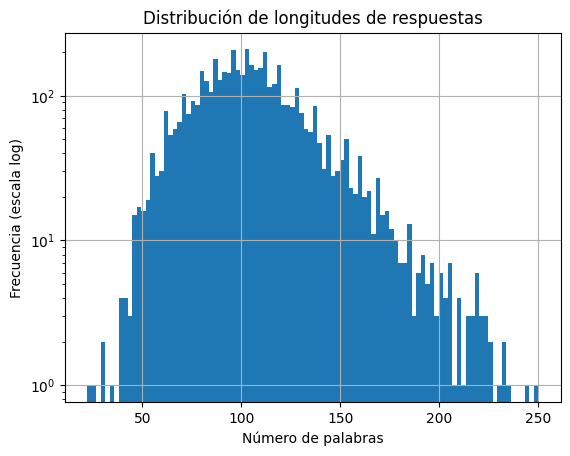

In [20]:
import matplotlib.pyplot as plt

longitudes = ds_final["train"]["num_words"]

plt.hist(longitudes, bins=100)
plt.yscale("log")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia (escala log)")
plt.title("Distribución de longitudes de respuestas")
plt.grid(True)
plt.show()